In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jlinops

import cupy as cp

/opt/conda/envs/jlinops/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [81]:
class GPUIASSolver:

    def __init__(self, F, R, y, hyperparams, noise_var=None, pdata={}):

        # Check that everything is on the correct device
     
        # Bind
        self.F = F
        self.y = y
        self.noise_var = noise_var
        self.R = R
        self.hyperparams = hyperparams
    
        # Some checks
        assert self.F.shape[1] == self.R.shape[1], "Shapes of forward and regularization operators do not agree!"
       
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

        assert not ( ( "noise_var" in self.hyperparams.keys() ) and ( noise_var is not None ) ), "Leave noise_var=None if specifying a hyperprior for the noise variance."
        
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.n = self.F.shape[1] # dimension of the unknown
        self.m = self.F.shape[0] # output size of forward operator
        self.k = self.R.shape[0] # output size of regularization operator
        
        if noise_var is None:
            self.updating_noise_var = True
        else:
            self.updating_noise_var = False

        if (self.pdata["W"] is not None) and (self.pdata["FWpinv"] is None):
            tmp = jlinops.QRPinvOperator( jlinops.MatrixLinearOperator(self.F.matmat(self.pdata["W"].A)) )
            self.pdata["FWpinv"] = tmp
      
        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, x0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True, x_update_device="cpu"):
        """Driver for the IAS solver.
        """

        # Handle noise var
        if self.updating_noise_var:
            noise_var_curr = 1.0
        else:
            noise_var_curr = self.noise_var
        
        # Handle initialization
        if x0 is None:
            x = np.ones(self.n)
        else:
            x = x0
        
        # Handle warmstarting
        if warmstarting:
            x_prev = x.copy()
        else:
            x_prev = None

        # Tracking
        n_cg_its_per_iteration = []
        obj_vals = []
        noise_vars = []
        converged = False
        n_iters = 0
        
        
        # Iterate
        for j in range(max_iters):
            
            # Update noise variance
            if self.updating_noise_var:
                noise_var_curr = self.noise_var_update(x)
            noise_vars.append(noise_var_curr)

            # Update prior thetas
            theta_curr = self.theta_update(x)

            # Update x
            x, n_cg_its = self.x_update(theta_curr, noise_var_curr, priorconditioning, x_update_solver_params, x_prev, x_update_device)
            if warmstarting:
                x_prev = x.copy()
            n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(x, theta_curr, noise_var_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, noise_var_prev, noise_var_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            noise_var_prev = noise_var_curr
            n_iters += 1

        data = {
            "x": x,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "noise_var": noise_var_curr,
            "noise_vars": np.asarray(noise_vars),
            "n_iters": n_iters
        }

        return data



    def x_update(self, theta, noise_var, priorconditioning=False, x_update_solver_params={}, x_prev=None, x_update_device="cpu"):
        """Returns the x-update for fixed local variance parameters theta.
        """
        
        # Whiten forward operator and data
        noise_stdev = np.sqrt(noise_var)
        Ftilde = (1.0/noise_stdev)*self.F.T
        ytilde = (1.0/noise_stdev)*self.y
        
        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R
        
        # If not using priorconditioning, solve original problem using CGLS without standardizing
        if not priorconditioning:

            # Solve using cgls

            if x_update_device == "cpu":
            
                cgls_solve = jlinops.trlstsq(Ftilde, Rtilde, ytilde, lam=1.0, initialization=x_prev, **x_update_solver_params)
                
                return cgls_solve["x"], cgls_solve["n_iters"]

            else:

                Ftilde = Ftilde.to_gpu()
                Rtilde = Rtilde.to_gpu()
                ytile = cp.asarray(ytilde)
                x_prev =  cp.asarray(x_prev)

                cgls_solve = jlinops.trlstsq(Ftilde, Rtilde, ytilde, lam=1.0, initialization=x_prev, **x_update_solver_params)

                x = cp.asnumpy(cgls_solve["x"])
                
                return x, cgls_solve["n_iters"]

        
        # If using priorconditioning
        else:

            if x_update_device == "cpu":
            
                # Build current Rpinv operator
                Rpinv = self.pdata["Rpinv_factory"](theta)
                
                # Solve using transformed CGLS
                cgls_solve = jlinops.trlstsq_standard_form(Ftilde, ytilde, Rpinv=Rpinv, R=Rtilde,
                                                           AWpinv=noise_stdev*self.pdata["FWpinv"], lam=1.0, shift=None, W=self.pdata["W"], initialization=x_prev, **x_update_solver_params)
                return cgls_solve["x"], cgls_solve["n_iters"]

            else:

                # Build current Rpinv operator
                Rpinv = self.pdata["Rpinv_factory"](theta)
                if Rpinv.device == "gpu":
                    pass
                else:
                    Rpinv = Rpinv.to_gpu()

                Ftilde = Ftilde.to_gpu()
                Rtilde = Rtilde.to_gpu()
                ytilde = cp.asarray(ytilde)
                x_prev =  cp.asarray(x_prev)
                Awpinv = self.pdata["FWpinv"].to_gpu()
                W = self.pdata["W"].to_gpu()
                
                # Solve using transformed CGLS
                cgls_solve = jlinops.trlstsq_standard_form(Ftilde, ytilde, Rpinv=Rpinv, R=Rtilde,
                                                           AWpinv=noise_stdev*Awpinv, lam=1.0, shift=None, W=W, initialization=x_prev, **x_update_solver_params)

                x = cp.asnumpy(cgls_solve["x"])
                 
                return x, cgls_solve["n_iters"]
            
        
        
    def theta_update(self, x):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (x) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def noise_var_update(self, x):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["noise_var"]["r"], self.hyperparams["noise_var"]["beta"], self.hyperparams["noise_var"]["vartheta"]
        eta = r*beta - ((self.F.shape[0]+2)/2)
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  np.linalg.norm(self.F @ x - self.y) / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + ((self.F.shape[0]+2)/2)
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            
            # final_times = z

            # # Sort the final times
            # argsort = final_times.argsort()
            # final_times_sorted = final_times[argsort]

            final_times_sorted = [z]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            #print(f"ODE sol: {ode_sol}")

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]
            xi = ode_sol[0]
            new_noise_var = vartheta*xi

            return new_noise_var




    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, x, theta, noise_var):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        gauss_like = (0.5/noise_var)*(np.linalg.norm( self.F.matvec(x) - self.y )**2)
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ x)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = gauss_like + cond_pr + hyperpr
        
        # Add part for noise var if needed
        if self.updating_noise_var:
            r, beta, vartheta = self.hyperparams["noise_var"]["r"], self.hyperparams["noise_var"]["beta"], self.hyperparams["noise_var"]["vartheta"]
            eta = (r*beta) - ((self.m + 2)/2)
            noise_contrib = ((noise_var/vartheta)**r) - eta*np.log(noise_var)
            obj += noise_contrib
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, noise_var_prev, noise_var_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
        noise_var_check = True
        if self.updating_noise_var:
            noise_var_check = (np.abs(noise_var_prev - noise_var_curr)/noise_var_prev) < eps
        
        if theta_check and noise_var_check:
            return True
        else:
            return False
        


# Example

In [82]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps
from scipy.sparse.linalg import cg as sp_cg

import matplotlib as mpl

# mpl.rcParams['text.usetex'] = True
# #mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')

from matplotlib.ticker import MaxNLocator

import jlinops
import sampi



dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}

In [83]:
def test_signal():

    dom = np.linspace(0, 1, 1000)
    result = np.zeros(1000)
    result = 2*np.sin( (50*np.pi)*dom ) + 25*dom
    result[400:] += 50
    result[700:] += 70

    return result

In [84]:
ground_truth = test_signal()
noise_var = 10.0
noise_sigma = np.sqrt(noise_var)
np.random.seed(0)
y_obs = ground_truth + noise_sigma*np.random.normal(size=len(ground_truth))
n = len(y_obs)

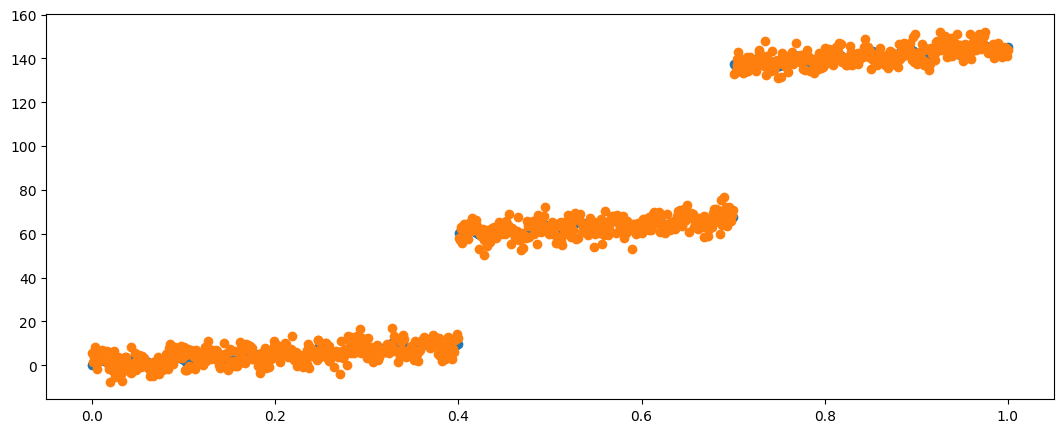

In [85]:
plt.figure(figsize=(13,5))
dom = np.linspace(0, 1, n)
plt.scatter(dom, ground_truth)
plt.scatter(dom, y_obs)
plt.show()

In [86]:
F = jlinops.IdentityOperator( (n,n) )

R1_mat, W1_mat = jlinops.first_order_derivative_1d(n, boundary="none") 
W1 = jlinops.MatrixLinearOperator(W1_mat)
R1 = jlinops.MatrixLinearOperator(R1_mat)

R2_mat, W2_mat = jlinops.second_order_derivative_1d(n, boundary="none")
W2 = jlinops.MatrixLinearOperator(W2_mat)
R2 = jlinops.MatrixLinearOperator(R2_mat)

R3_mat, W3_mat = jlinops.third_order_derivative_1d(n, boundary="none")
W3 = jlinops.MatrixLinearOperator(W3_mat)
R3 = jlinops.MatrixLinearOperator(R3_mat)

In [87]:
delta = 1e-8

def R1pinv_factory(theta):
    return jlinops.BandedCholeskyPinvOperator( jlinops.MatrixLinearOperator( sps.diags( 1.0/np.sqrt(theta) ) @ R1_mat ), delta=delta )

pdata1 = {
    "W": W1,
    "Rpinv_factory": R1pinv_factory,
}


def R2pinv_factory(theta):
    return jlinops.BandedCholeskyPinvOperator( jlinops.MatrixLinearOperator( sps.diags( 1.0/np.sqrt(theta) ) @ R2_mat ), delta=delta )

pdata2 = {
    "W": W2,
    "Rpinv_factory": R2pinv_factory,
}


def R3pinv_factory(theta):
    return jlinops.BandedCholeskyPinvOperator( jlinops.MatrixLinearOperator( sps.diags( 1.0/np.sqrt(theta) ) @ R3_mat ), delta=delta )

pdata3 = {
    "W": W3,
    "Rpinv_factory": R3pinv_factory,
}

In [88]:
# # # Prior parameters
# # reg_lambda = 1e1
# # vartheta = 2/(reg_lambda**2)
# # hyperparams = {
# #     "prior": {
# #         "r": 1.0,
# #         "beta": 1.5 + 1e-2,
# #         "vartheta": vartheta,
# #     },
# #     # "noise_var": {
# #     #     "r": -1.0,
# #     #     "beta": 1,

# #     #     "vartheta": 1e-4,
# #     # }
# # }


# Prior parameters

reg_lambda = 0.5*1e1
vartheta = 2/(reg_lambda**2)
hyperparams_r1 = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,

        "vartheta": 1e-4,
    }
}


reg_lambda = 0.5*1e1
vartheta = 2/(reg_lambda**2)
hyperparams_r2 = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,

        "vartheta": 1e-4,
    }
}


reg_lambda = 0.5*1e1
vartheta = 2/(reg_lambda**2)
hyperparams_r3 = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}





# # Prior parameters


# vartheta = 1e-3

# hyperparams_r1 = {
#     "prior": {
#         "r": -1.0,
#         "beta": 1.0,
#         "vartheta": vartheta,
#     },
#     "noise_var": {
#         "r": -1.0,
#         "beta": 1,
#         "vartheta": 1e-4,
#     }
# }


# hyperparams_r2 = {
#     "prior": {
#         "r": -1.0,
#         "beta": 1.0,
#         "vartheta": vartheta,
#     },
#     "noise_var": {
#         "r": -1.0,
#         "beta": 1,
#         "vartheta": 1e-4,
#     }
# }


# hyperparams_r3 = {
#     "prior": {
#         "r": -1.0,
#         "beta": 1.0,
#         "vartheta": vartheta,
#     },
#     "noise_var": {
#         "r": -1.0,
#         "beta": 1,
#         "vartheta": 1e-4,
#     }
# }




# Create solver
# solver_r1 = sampi.IASSolver(F, R1, y_obs, hyperparams, noise_var=noise_var, pdata=pdata1)
# solver_r2 = sampi.IASSolver(F, R2, y_obs, hyperparams, noise_var=noise_var, pdata=pdata2)
# solver_r3 = sampi.IASSolver(F, R3, y_obs, hyperparams, noise_var=noise_var, pdata=pdata3)

solver_r1 = GPUIASSolver(F, R1, y_obs, hyperparams_r1, noise_var=None, pdata=pdata1)
solver_r2 = GPUIASSolver(F, R2, y_obs, hyperparams_r2, noise_var=None, pdata=pdata2)
solver_r3 = GPUIASSolver(F, R3, y_obs, hyperparams_r3, noise_var=None, pdata=pdata3)

In [89]:
solver_r1.pdata

{'W': <1000x1 MatrixLinearOperator with dtype=float64>,
 'Rpinv_factory': <function __main__.R1pinv_factory(theta)>,
 'Rinv': None,
 'FWpinv': <1x1000 QRPinvOperator with dtype=float64>}

In [90]:
# Initialize everything at the least-squares reconstruction?
x0_r1, _ = sp_cg( (F.T @ F) + 1.0*(R1.T @ R1), F.T @ y_obs, tol=1e-4 )
x0_r2, _ = sp_cg( (F.T @ F) + 1.0*(R2.T @ R2), F.T @ y_obs, tol=1e-4 )
x0_r3, _ = sp_cg( (F.T @ F) + 1.0*(R3.T @ R3), F.T @ y_obs, tol=1e-4 )

In [91]:
mode = "gpu"

In [92]:
data_r1 = solver_r1.solve(max_iters=100, x0=x0_r1, 
                          priorconditioning=False, early_stopping=True, 
                          warmstarting=True, eps=1e-3,
                          x_update_solver_params={"tol":1e-3},
                         x_update_device=mode)

In [93]:
data_pr1 = solver_r1.solve(max_iters=100, x0=x0_r1, 
                           priorconditioning=True, early_stopping=True, 
                           warmstarting=True, eps=1e-4,
                           x_update_solver_params={"tol":1e-3},
                          x_update_device=mode)

In [94]:
data_r2 = solver_r2.solve(max_iters=100, x0=x0_r2, 
                          priorconditioning=False, early_stopping=True, 
                          warmstarting=True, eps=1e-4,
                          x_update_solver_params={"tol":1e-3},
                         x_update_device=mode)

In [95]:
data_pr2 = solver_r2.solve(max_iters=100, x0=x0_r2, 
                          priorconditioning=True, early_stopping=True, 
                          warmstarting=True, eps=1e-4,
                          x_update_solver_params={"tol":1e-3},
                          x_update_device=mode)

In [96]:
data_r3 = solver_r3.solve(max_iters=100, x0=x0_r3, 
                           priorconditioning=False, early_stopping=True, 
                           warmstarting=True, eps=1e-4,
                           x_update_solver_params={"tol":1e-3},
                         x_update_device=mode)

In [97]:
data_pr3 = solver_r3.solve(max_iters=100, x0=x0_r3, 
                           priorconditioning=True, early_stopping=True, 
                           warmstarting=True, eps=1e-4,
                           x_update_solver_params={"tol":1e-3},
                          x_update_device=mode)

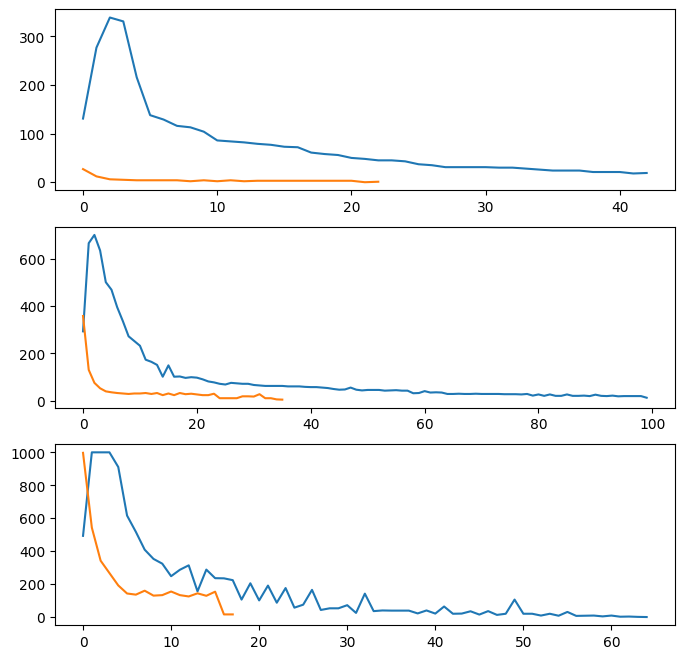

In [107]:
fig, axs = plt.subplots(3,1,figsize=(8,8))

axs[0].plot(data_r1["n_cg_its_per_iteration"])
axs[0].plot(data_pr1["n_cg_its_per_iteration"])

axs[1].plot(data_r2["n_cg_its_per_iteration"])
axs[1].plot(data_pr2["n_cg_its_per_iteration"])

axs[2].plot(data_r3["n_cg_its_per_iteration"])
axs[2].plot(data_pr3["n_cg_its_per_iteration"])

plt.show()

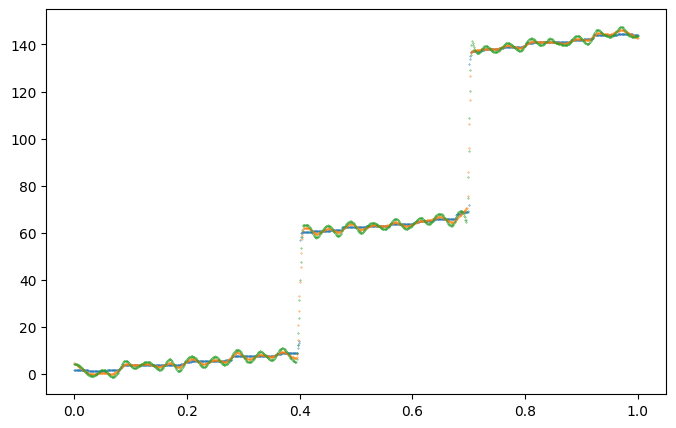

In [108]:
plt.figure(figsize=(8,5))
plt.scatter(dom, data_r1["x"], s=0.1)
plt.scatter(dom, data_r2["x"], s=0.1)
plt.scatter(dom, data_r3["x"], s=0.1)
#plt.plot(dom, ground_truth)
plt.show()

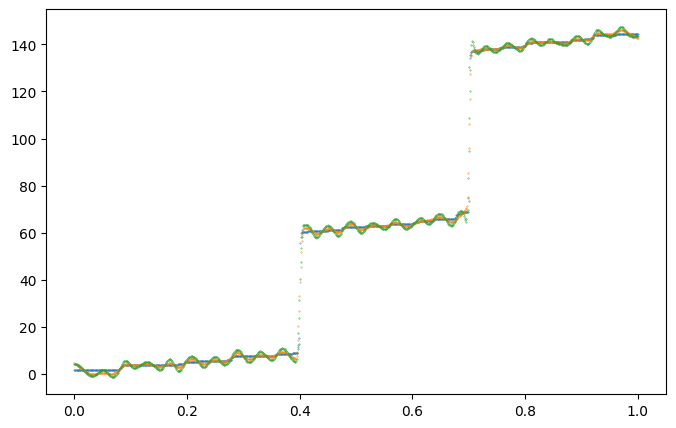

In [109]:
plt.figure(figsize=(8,5))
plt.scatter(dom, data_pr1["x"], s=0.1)
plt.scatter(dom, data_pr2["x"], s=0.1)
plt.scatter(dom, data_pr3["x"], s=0.1)
#plt.plot(dom, ground_truth)
plt.show()

In [110]:
data_r1["noise_var"]

10.85689617746007

In [111]:
data_pr1["noise_var"]

10.911850836767547

In [112]:
data_r2["noise_var"]

13.008586502082933

In [113]:
data_pr2["noise_var"]

12.959680964501317

In [114]:
data_r3["noise_var"]

11.257064769811711

In [115]:
data_pr3["noise_var"]

11.24636291846108